In [9]:
import sys
import os
from IPython.display import Markdown
from env_key_manager import APIKeyManager

APIKeyManager().setup_api_key([
    "DEEPSEEK_API_KEY", 
    "LANGSMITH_ENDPOINT", 
    "LANGSMITH_API_KEY", 
    "LANGSMITH_PROJECT"
])

os.environ['LANGSMITH_TRACING'] = "true"

# 查看Python版本
!python -V
# 查看安装的库
if 'win' in sys.platform.lower():
    !pip list | findstr "lang openai llm tiktoken chromadb cryptography duck unstructured numpy scipy"
else:
    !pip list | grep -E "lang|openai|llm|tiktoken|chromadb|cryptography|duck|unstructured|numpy|scipy"

Python 3.10.16
chromadb                                 0.6.3
cryptography                             44.0.2
duckduckgo_search                        6.3.7
langchain                                0.3.21
langchain-chroma                         0.2.2
langchain-community                      0.3.20
langchain-core                           0.3.49
langchain-deepseek                       0.1.3
langchain-openai                         0.3.11
langchain-text-splitters                 0.3.7
langgraph                                0.3.21
langgraph-checkpoint                     2.0.23
langgraph-prebuilt                       0.1.7
langgraph-sdk                            0.1.60
langserve                                0.3.1
langsmith                                0.3.8
numpy                                    1.26.4
openai                                   1.69.0
scipy                                    1.15.2
tiktoken                                 0.9.0


# 基于SQL数据构建问答系统

:::info 前提条件

本指南假定您熟悉以下概念：

- [聊天模型](/docs/concepts/chat_models)
- [工具](/docs/concepts/tools)
- [智能体](/docs/concepts/agents)
- [LangGraph](/docs/concepts/architecture/#langgraph)

:::

让LLM系统能够查询结构化数据，与处理非结构化文本数据存在本质差异。对于非结构化文本，通常的做法是生成可针对向量数据库进行检索的文本；而处理结构化数据时，LLM往往需要编写并执行特定领域语言（DSL）的查询语句，例如SQL。本指南将详细介绍在数据库表格数据上构建问答系统的基本方法，涵盖基于[链式结构](/docs/tutorials/sql_qa#chains)和[代理机制](/docs/tutorials/sql_qa#agents)的两种实现方案。这些系统能让我们用自然语言提问数据库中的数据，并获取自然语言形式的回答。两者的核心区别在于：代理机制可以循环多次查询数据库，直到得出问题答案为止。

## ⚠️ 安全提示 ⚠️

构建基于SQL数据库的问答系统需要执行模型生成的SQL查询语句。这一过程存在固有风险。请确保您的数据库连接权限始终按照链/代理程序的需求进行最小化范围配置。虽然这不能完全消除构建模型驱动系统的风险，但能有效降低风险。有关通用安全最佳实践的更多信息，[请参阅此处](/docs/security)。


## 架构

从高层次来看，这些系统的步骤如下：

1. **将问题转换为SQL查询**：模型将用户输入转换为SQL查询。
2. **执行SQL查询**：执行该查询。
3. **回答问题**：模型利用查询结果对用户输入作出回应。

请注意，查询CSV数据可以采用类似的方法。更多详情请参阅我们关于CSV数据问答的[操作指南](/docs/how_to/sql_csv)。

![sql_usecase.png](../../static/img/sql_usecase.png)

## 安装设置

首先，获取所需的软件包并设置环境变量：

In [ ]:
# %%capture --no-stderr
# %pip install --upgrade --quiet langchain-community langchainhub langgraph

### 示例数据

以下示例将使用 SQLite 连接 Chinook 数据库，这是一个代表数字媒体商店的示例数据库。按照[这些安装步骤](https://database.guide/2-sample-databases-sqlite/)在本笔记本同一目录下创建 `Chinook.db` 文件。您也可以通过命令行下载并构建该数据库：
```bash
curl -s https://raw.githubusercontent.com/lerocha/chinook-database/master/ChinookDatabase/DataSources/Chinook_Sqlite.sql | sqlite3 Chinook.db
```


现在，`Chinook.db` 已存在于我们的目录中，我们可以使用基于 SQLAlchemy 的 `SQLDatabase` 类与之交互：

In [10]:
from langchain_community.utilities import SQLDatabase

db = SQLDatabase.from_uri("sqlite:///Chinook.db")
print(db.dialect)
print(db.get_usable_table_names())
import pandas as pd
result = db.run("SELECT * FROM Artist LIMIT 10;")
pd.DataFrame(eval(result), columns=['ArtistId', 'Name'])

sqlite
['Album', 'Artist', 'Customer', 'Employee', 'Genre', 'Invoice', 'InvoiceLine', 'MediaType', 'Playlist', 'PlaylistTrack', 'Track']


,ArtistId,Name
0,1,AC/DC
1,2,Accept
2,3,Aerosmith
3,4,Alanis Morissette
4,5,Alice In Chains
5,6,Antônio Carlos Jobim
6,7,Apocalyptica
7,8,Audioslave
8,9,BackBeat
9,10,Billy Cobham


太好了！我们已经有了一个可以查询的 SQL 数据库。现在让我们尝试将其连接到 LLM。

## 链式结构 {#chains}

链是由可预测步骤组成的结构。在[LangGraph](/docs/concepts/architecture/#langgraph)中，我们可以通过简单的节点序列来表示一个链。让我们创建一个步骤序列，在给定一个问题时执行以下操作：
- 将问题转换为SQL查询；
- 执行查询；
- 使用结果来回答原始问题。

当前方案不支持某些场景。例如，该系统会对任何用户输入（包括"hello"）执行SQL查询。值得注意的是，如下文所示，部分问题需要执行多个查询才能解答。我们将在"智能体"章节处理这些场景。

### 应用状态

我们应用的 LangGraph [状态](https://langchain-ai.github.io/langgraph/concepts/low_level/#state) 控制着输入应用的数据、在步骤间传递的数据以及应用输出的数据。它通常是一个 `TypedDict`，但也可以是 [Pydantic BaseModel](https://langchain-ai.github.io/langgraph/how-tos/state-model/)。

对于此应用，我们只需记录输入问题、生成的查询语句、查询结果以及生成的答案：

In [11]:
from typing_extensions import TypedDict


class State(TypedDict):
    question: str   # 问题
    query: str    # 查询语句
    result: str     # 结果
    answer: str     # 答案

现在，我们只需要一些函数来操作这个状态并填充其内容。

### 将问题转换为SQL查询

第一步是将用户输入转换为SQL查询。为了可靠地获取SQL查询（不含Markdown格式及解释说明内容），我们将利用LangChain的[结构化输出](/docs/concepts/structured_outputs/)抽象功能。

为我们的应用程序选择一个聊天模型：

import ChatModelTabs from "@theme/ChatModelTabs";

<ChatModelTabs customVarName="llm" />


In [12]:
# | output: false
# | echo: false

from langchain_deepseek import ChatDeepSeek

llm = ChatDeepSeek(model="deepseek-chat", temperature=0)

我们将从[提示词中心](https://smith.langchain.com/hub)提取一个提示词来指导模型。

In [14]:
from langchain import hub

query_prompt_template = hub.pull("langchain-ai/sql-query-system-prompt")

assert len(query_prompt_template.messages) == 1
query_prompt_template.messages[0].pretty_print()

================================ System Message ================================

Given an input question, create a syntactically correct {dialect} query to run to help find the answer. Unless the user specifies in his question a specific number of examples they wish to obtain, always limit your query to at most {top_k} results. You can order the results by a relevant column to return the most interesting examples in the database.

Never query for all the columns from a specific table, only ask for a the few relevant columns given the question.

Pay attention to use only the column names that you can see in the schema description. Be careful to not query for columns that do not exist. Also, pay attention to which column is in which table.

Only use the following tables:
{table_info}

Question: {input}


In [27]:
# 中文翻译智能体
from langchain.prompts import PromptTemplate
from langchain_core.output_parsers import StrOutputParser

# 创建一个翻译智能体
translate_agent = (
    PromptTemplate(
        template="将以下文本翻译成中文: {text}",
        input_variables=["text"]
    ) |
    llm |
    StrOutputParser()
)

Markdown(translate_agent.invoke(query_prompt_template.messages[0].prompt.template))

给定一个输入问题，请构建符合{dialect}语法规范的查询语句以获取答案。除非用户在问题中明确指定需要获取的具体示例数量，否则始终将查询结果限制在最多{top_k}条。可以通过相关列对结果进行排序，以返回数据库中最具价值的数据。

禁止查询特定表的所有列，仅根据问题需求选择必要的几列。

务必仅使用模式描述中可见的列名，注意避免查询不存在的列。同时需特别注意各列所属的表。

可用的表如下：
{table_info}

问题：{input}

提示中包含几个需要填充的参数，例如SQL方言和表结构。LangChain的[SQLDatabase](https://python.langchain.com/api_reference/community/utilities/langchain_community.utilities.sql_database.SQLDatabase.html)对象提供了辅助方法来实现这一功能。我们的`write_query`步骤只需填充这些参数，并提示模型生成SQL查询：

In [28]:
from typing_extensions import Annotated
from typing import TypedDict


class QueryOutput(TypedDict):
    """生成的SQL查询。"""

    query: Annotated[str, ..., "语法有效的SQL查询。"]


def write_query(state: State):
    """生成SQL查询以获取信息。"""
    prompt = query_prompt_template.invoke(
        {
            "dialect": db.dialect,
            "top_k": 10,
            "table_info": db.get_table_info(),
            "input": state["question"],
        }
    )
    structured_llm = llm.with_structured_output(QueryOutput)
    result = structured_llm.invoke(prompt)
    return {"query": result["query"]}

让我们来测试一下：

In [29]:
write_query({"question": "公司有多少员工？"})

{'query': 'SELECT COUNT(*) AS TotalEmployees FROM Employee;'}

### 执行查询

**这是创建SQL链中最危险的部分。** 请仔细考虑是否可以对您的数据运行自动化查询。尽可能最小化数据库连接权限。考虑在执行查询前为您的链添加人工审批步骤（如下所示）。

要执行查询，我们将从 [langchain-community](/docs/concepts/architecture/#langchain-community) 加载一个工具。我们的 `execute_query` 节点将直接封装该工具：

In [30]:
from langchain_community.tools.sql_database.tool import QuerySQLDatabaseTool


def execute_query(state: State):
    """执行SQL查询。"""
    execute_query_tool = QuerySQLDatabaseTool(db=db)
    return {"result": execute_query_tool.invoke(state["query"])}

测试此步骤：

In [31]:
execute_query({"query": "SELECT COUNT(*) AS TotalEmployees FROM Employee;"})

{'result': '[(8,)]'}

### 生成答案

最后，我们的最终步骤是根据从数据库中提取的信息生成问题的答案：

In [32]:
def generate_answer(state: State):
    """使用检索到的信息作为上下文来回答问题。"""
    prompt = (
        "根据以下用户问题、相应的SQL查询和SQL结果，回答用户问题。\n\n"
        f'问题: {state["question"]}\n'
        f'SQL查询: {state["query"]}\n'
        f'SQL结果: {state["result"]}'
    )
    response = llm.invoke(prompt)
    return {"answer": response.content}

### 使用LangGraph进行编排

最后，我们将应用程序编译为一个单一的 `graph` 对象。在本例中，我们只是将这三个步骤连接成一个单一的序列。

In [33]:
from langgraph.graph import START, StateGraph

graph_builder = StateGraph(State).add_sequence(
    [write_query, execute_query, generate_answer]
)
graph_builder.add_edge(START, "write_query")
graph = graph_builder.compile()

LangGraph还内置了用于可视化应用程序控制流的实用工具：

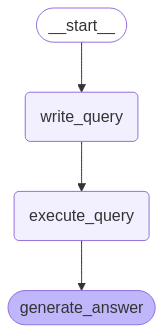

In [34]:
from IPython.display import Image, display

display(Image(graph.get_graph().draw_mermaid_png()))

让我们测试我们的应用程序！请注意，我们可以流式传输各个步骤的结果：

In [35]:
for step in graph.stream(
    {"question": "公司有多少员工？"}, stream_mode="updates"
):
    print(step)

{'write_query': {'query': 'SELECT COUNT(*) AS TotalEmployees FROM Employee;'}}
{'execute_query': {'result': '[(8,)]'}}
{'generate_answer': {'answer': '公司共有8名员工。'}}


查看 [LangSmith 追踪记录](https://smith.langchain.com/public/30a79380-6ba6-46af-8bd9-5d1df0b9ccca/r)。

### 人在回路

LangGraph 支持许多对此工作流程非常有用的功能。其中之一是[人工介入循环](https://langchain-ai.github.io/langgraph/concepts/human_in_the_loop/)：我们可以在敏感步骤（例如执行SQL查询）之前中断应用程序，以便进行人工审核。这得益于LangGraph的[持久化](https://langchain-ai.github.io/langgraph/concepts/persistence/)层，该层将运行进度保存到您选择的存储中。下面，我们指定了内存存储：

In [14]:
from langgraph.checkpoint.memory import MemorySaver

memory = MemorySaver()
graph = graph_builder.compile(checkpointer=memory, interrupt_before=["execute_query"])

# Now that we're using persistence, we need to specify a thread ID
# so that we can continue the run after review.
config = {"configurable": {"thread_id": "1"}}

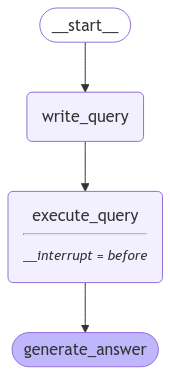

In [15]:
display(Image(graph.get_graph().draw_mermaid_png()))

让我们重复相同的运行，加入一个简单的“是/否”审批步骤：

In [16]:
for step in graph.stream(
    {"question": "How many employees are there?"},
    config,
    stream_mode="updates",
):
    print(step)

try:
    user_approval = input("Do you want to go to execute query? (yes/no): ")
except Exception:
    user_approval = "no"

if user_approval.lower() == "yes":
    # If approved, continue the graph execution
    for step in graph.stream(None, config, stream_mode="updates"):
        print(step)
else:
    print("Operation cancelled by user.")

{'write_query': {'query': 'SELECT COUNT(EmployeeId) AS EmployeeCount FROM Employee;'}}
{'__interrupt__': ()}


Do you want to go to execute query? (yes/no):  yes


{'execute_query': {'result': '[(8,)]'}}
{'generate_answer': {'answer': 'There are 8 employees.'}}


请参阅[此](https://langchain-ai.github.io/langgraph/concepts/human_in_the_loop/) LangGraph指南以获取更多详细信息和示例。

### 后续步骤

对于更复杂的查询生成，我们可能需要创建少量示例提示或添加查询检查步骤。想了解这类高级技巧及更多内容，请查阅：

* [提示策略](/docs/how_to/sql_prompting): 高级提示工程技术。
* [查询检查](/docs/how_to/sql_query_checking): 新增查询验证与错误处理功能。
* [大型数据库](/docs/how_to/sql_large_db)：处理大型数据库的技术。

## 代理 {#agents}

[智能体](/docs/concepts/agents)利用大语言模型的推理能力在执行过程中做出决策。使用智能体可以让您在查询生成和执行过程中获得额外的自主裁量权。虽然它们的行为比上述"链式结构"更难预测，但具有以下优势：

- 他们可以根据需要多次查询数据库以回答用户问题。
- 它们能够通过运行生成的查询、捕获回溯并正确重新生成，从而从错误中恢复。
- 它们能够根据数据库的结构以及数据库的内容（例如描述特定表格）来回答问题。


下面我们构建一个最小化的SQL代理。我们将使用LangChain的[SQLDatabaseToolkit](https://python.langchain.com/api_reference/community/agent_toolkits/langchain_community.agent_toolkits.sql.toolkit.SQLDatabaseToolkit.html)为其配备一组工具。借助LangGraph的[预构建ReAct代理构造器](https://langchain-ai.github.io/langgraph/how-tos/#langgraph.prebuilt.chat_agent_executor.create_react_agent)，只需一行代码即可实现。

:::提示

查看 LangGraph 的 [SQL 代理教程](https://langchain-ai.github.io/langgraph/tutorials/sql-agent/)，了解更高级的 SQL 代理实现方案。

:::

`SQLDatabaseToolkit` 包含以下功能的工具：

* 创建并执行查询
* 检查查询语法
* 获取表描述
* ……以及更多

In [17]:
from langchain_community.agent_toolkits import SQLDatabaseToolkit

toolkit = SQLDatabaseToolkit(db=db, llm=llm)

tools = toolkit.get_tools()

tools

[QuerySQLDatabaseTool(description="Input to this tool is a detailed and correct SQL query, output is a result from the database. If the query is not correct, an error message will be returned. If an error is returned, rewrite the query, check the query, and try again. If you encounter an issue with Unknown column 'xxxx' in 'field list', use sql_db_schema to query the correct table fields.", db=<langchain_community.utilities.sql_database.SQLDatabase object at 0x10d5f9120>),
 InfoSQLDatabaseTool(description='Input to this tool is a comma-separated list of tables, output is the schema and sample rows for those tables. Be sure that the tables actually exist by calling sql_db_list_tables first! Example Input: table1, table2, table3', db=<langchain_community.utilities.sql_database.SQLDatabase object at 0x10d5f9120>),
 ListSQLDatabaseTool(db=<langchain_community.utilities.sql_database.SQLDatabase object at 0x10d5f9120>),
 QuerySQLCheckerTool(description='Use this tool to double check if your 

### 系统提示

我们还需要为我们的智能体加载一个系统提示。这将包含关于如何行事的指令。

In [18]:
from langchain import hub

prompt_template = hub.pull("langchain-ai/sql-agent-system-prompt")

assert len(prompt_template.messages) == 1
prompt_template.messages[0].pretty_print()

================================ System Message ================================

You are an agent designed to interact with a SQL database.
Given an input question, create a syntactically correct {dialect} query to run, then look at the results of the query and return the answer.
Unless the user specifies a specific number of examples they wish to obtain, always limit your query to at most {top_k} results.
You can order the results by a relevant column to return the most interesting examples in the database.
Never query for all the columns from a specific table, only ask for the relevant columns given the question.
You have access to tools for interacting with the database.
Only use the below tools. Only use the information returned by the below tools to construct your final answer.
You MUST double check your query before executing it. If you get an error while executing a query, rewrite the query and try again.

DO NOT make any DML statements (INSERT, UPDATE, DELETE, DROP etc.) to th

让我们填充提示中高亮的参数：

In [19]:
system_message = prompt_template.format(dialect="SQLite", top_k=5)

### 初始化代理

我们将使用一个预构建的[LangGraph](/docs/concepts/architecture/#langgraph)智能体来构建我们的智能体

In [20]:
from langchain_core.messages import HumanMessage
from langgraph.prebuilt import create_react_agent

agent_executor = create_react_agent(llm, tools, prompt=system_message)

思考代理如何回应以下问题：

In [21]:
question = "Which country's customers spent the most?"

for step in agent_executor.stream(
    {"messages": [{"role": "user", "content": question}]},
    stream_mode="values",
):
    step["messages"][-1].pretty_print()

================================ Human Message =================================

Which country's customers spent the most?
================================== Ai Message ==================================
Tool Calls:
  sql_db_list_tables (call_tFp7HYD6sAAmCShgeqkVZH6Q)
 Call ID: call_tFp7HYD6sAAmCShgeqkVZH6Q
  Args:
================================= Tool Message =================================
Name: sql_db_list_tables

Album, Artist, Customer, Employee, Genre, Invoice, InvoiceLine, MediaType, Playlist, PlaylistTrack, Track
================================== Ai Message ==================================
Tool Calls:
  sql_db_schema (call_KJZ1Jx6JazyDdJa0uH1UeiOz)
 Call ID: call_KJZ1Jx6JazyDdJa0uH1UeiOz
  Args:
    table_names: Customer, Invoice
================================= Tool Message =================================
Name: sql_db_schema


CREATE TABLE "Customer" (
	"CustomerId" INTEGER NOT NULL, 
	"FirstName" NVARCHAR(40) NOT NULL, 
	"LastName" NVARCHAR(20) NOT NULL, 
	"Company"

你也可以使用 [LangSmith 追踪](https://smith.langchain.com/public/8af422aa-b651-4bfe-8683-e2a7f4ccd82c/r) 来可视化这些步骤及相关的元数据。

请注意，代理会执行多次查询，直到获取所需信息为止：
1. 列出可用表格；
2. 检索三个表的模式结构；
3. 通过连接操作查询多个表。

随后，代理能够利用最终查询的结果生成对原始问题的回答。

代理同样可以处理定性问题：

In [22]:
question = "Describe the playlisttrack table"

for step in agent_executor.stream(
    {"messages": [{"role": "user", "content": question}]},
    stream_mode="values",
):
    step["messages"][-1].pretty_print()

================================ Human Message =================================

Describe the playlisttrack table
================================== Ai Message ==================================
Tool Calls:
  sql_db_list_tables (call_fMF8eTmX5TJDJjc3Mhdg52TI)
 Call ID: call_fMF8eTmX5TJDJjc3Mhdg52TI
  Args:
================================= Tool Message =================================
Name: sql_db_list_tables

Album, Artist, Customer, Employee, Genre, Invoice, InvoiceLine, MediaType, Playlist, PlaylistTrack, Track
================================== Ai Message ==================================
Tool Calls:
  sql_db_schema (call_W8Vkk4NEodkAAIg8nexAszUH)
 Call ID: call_W8Vkk4NEodkAAIg8nexAszUH
  Args:
    table_names: PlaylistTrack
================================= Tool Message =================================
Name: sql_db_schema


CREATE TABLE "PlaylistTrack" (
	"PlaylistId" INTEGER NOT NULL, 
	"TrackId" INTEGER NOT NULL, 
	PRIMARY KEY ("PlaylistId", "TrackId"), 
	FOREIGN KEY("TrackI

### 处理高基数列

为了筛选包含专有名词（如地址、歌曲名或艺术家名）的列，我们首先需要仔细核对拼写以确保数据筛选的准确性。

我们可以通过创建一个包含数据库中所有不同专有名词的向量存储来实现这一点。然后，每当用户在问题中包含专有名词时，我们可以让智能体查询该向量存储，以找到该单词的正确拼写。通过这种方式，智能体在构建目标查询之前，能够确保理解用户所指的实体。

首先我们需要获取每个所需实体的唯一值，为此我们定义一个将结果解析为元素列表的函数：

In [24]:
import ast
import re


def query_as_list(db, query):
    res = db.run(query)
    res = [el for sub in ast.literal_eval(res) for el in sub if el]
    res = [re.sub(r"\b\d+\b", "", string).strip() for string in res]
    return list(set(res))


artists = query_as_list(db, "SELECT Name FROM Artist")
albums = query_as_list(db, "SELECT Title FROM Album")
albums[:5]

['In Through The Out Door',
 'Transmission',
 'Battlestar Galactica (Classic), Season',
 'A Copland Celebration, Vol. I',
 'Quiet Songs']

通过此函数，我们可以创建一个**检索器工具**，供智能体根据自身判断执行。

让我们为这一步选择一个[嵌入模型](/docs/integrations/text_embedding/)和[向量数据库](/docs/integrations/vectorstores/)：

**选择嵌入模型**：

import EmbeddingTabs from "@theme/EmbeddingTabs";

<EmbeddingTabs/>

In [25]:
# | output: false
# | echo: false

from langchain_openai import OpenAIEmbeddings

embeddings = OpenAIEmbeddings()

**选择向量存储**：

import VectorStoreTabs from "@theme/VectorStoreTabs";

<VectorStoreTabs/>

In [26]:
# | output: false
# | echo: false

from langchain_core.vectorstores import InMemoryVectorStore

vector_store = InMemoryVectorStore(embeddings)

我们现在可以构建一个检索工具，用于在数据库中搜索相关的专有名词：

In [27]:
from langchain.agents.agent_toolkits import create_retriever_tool

_ = vector_store.add_texts(artists + albums)
retriever = vector_store.as_retriever(search_kwargs={"k": 5})
description = (
    "Use to look up values to filter on. Input is an approximate spelling "
    "of the proper noun, output is valid proper nouns. Use the noun most "
    "similar to the search."
)
retriever_tool = create_retriever_tool(
    retriever,
    name="search_proper_nouns",
    description=description,
)

让我们来试试看：

In [28]:
print(retriever_tool.invoke("Alice Chains"))

Alice In Chains

Alanis Morissette

Pearl Jam

Pearl Jam

Audioslave


这样，如果智能体确定需要基于类似"Alice Chains"这样的艺术家编写过滤器，它可以首先使用检索工具来观察某一列的相关值。

综上所述：

In [31]:
# Add to system message
suffix = (
    "If you need to filter on a proper noun like a Name, you must ALWAYS first look up "
    "the filter value using the 'search_proper_nouns' tool! Do not try to "
    "guess at the proper name - use this function to find similar ones."
)

system = f"{system_message}\n\n{suffix}"

tools.append(retriever_tool)

agent = create_react_agent(llm, tools, prompt=system)

In [34]:
question = "How many albums does alis in chain have?"

for step in agent.stream(
    {"messages": [{"role": "user", "content": question}]},
    stream_mode="values",
):
    step["messages"][-1].pretty_print()

================================ Human Message =================================

How many albums does alis in chain have?
================================== Ai Message ==================================
Tool Calls:
  search_proper_nouns (call_8ryjsRPLAr79mM3Qvnq6gTOH)
 Call ID: call_8ryjsRPLAr79mM3Qvnq6gTOH
  Args:
    query: alis in chain
================================= Tool Message =================================
Name: search_proper_nouns

Alice In Chains

Aisha Duo

Xis

Da Lama Ao Caos

A-Sides
================================== Ai Message ==================================
Tool Calls:
  sql_db_list_tables (call_NJjtCpU89MBMplssjn1z0xzq)
 Call ID: call_NJjtCpU89MBMplssjn1z0xzq
  Args:
  search_proper_nouns (call_1BfrueC9koSIyi4OfMu2Ao8q)
 Call ID: call_1BfrueC9koSIyi4OfMu2Ao8q
  Args:
    query: Alice In Chains
================================= Tool Message =================================
Name: search_proper_nouns

Alice In Chains

Pearl Jam

Pearl Jam

Foo Fighters

Soundga

如我们所见，无论是在流式处理的步骤中，还是在[LangSmith追踪记录](https://smith.langchain.com/public/1d757ed2-5688-4458-9400-023594e2c5a7/r)里，智能体都使用了`search_proper_nouns`工具来核实如何针对这位特定艺术家正确查询数据库。